In [1]:
%matplotlib inline

import numpy as np
from scipy.linalg import toeplitz

from matplotlib import pyplot as plt

In this notebook I will attempt to reproduce some of the results from Chapter 6 of [_Numerical Bayesian Methods Applied to Signal Processing_](https://link.springer.com/book/10.1007/978-1-4612-0717-7) by J. Ó Ruanaidh & W. Fitzgerald in which maximum likelihood and Gibbs sampling methods are used to interpolate over missing samples of a time series. The time series' are assumed to be generated through a Gaussian autoregressive process. The analysis uses some simulated time series as well as real audio data. The reason for performing interpolation might be due to having to remove a section of audio that contains a disturbance and then wanting to smoothly fill in the gap in a way that due not unduly affect the audio.

Let's start with some definitions. We have a time series dataset consisting of $N$ samples:

\begin{equation}\label{eq:x}
\mathbf{x} = \{x_1, x_2, \dots, x_N\}.
\end{equation}

In the case where we need to perform interpolation, the samples $\{x_1, \dots, x_m\}$ and $\{x_{m+k}, \dots, x_N\}$ are known, while there are $k$ missing samples $\{x_{m}, \dots, x_{m+k-1}\}$. We can call the known samples:

\begin{equation}\label{eq:y}
\mathbf{y} = \{x_1, \dots, x_m, x_{m+k}, x_N\},
\end{equation}

and the missing samples:

\begin{equation}\label{eq:z}
\mathbf{z} = \{x_{m}, \dots, x_{m+k-1}\}.
\end{equation}

The samples are assumed to be produced by some [autoregressive process](https://en.wikipedia.org/wiki/Autoregressive_model) given by:

\begin{equation}\label{eq:autoregx}
x_{i} = \left(\sum_{j=1}^{p} \theta_j x_{i-j}\right) + e_i, 
\end{equation}

where $p$ is the order of the autoregressive mode, $\theta$ are the parameters that define the model and $e_i$ is some additive (stationary, white, Gaussian) noise.

## The likelihood

Given data consisting of the set of known samples $\mathbf{y}$ and the generative model for the samples

\begin{equation}\label{eq:autorega}
a_i(\mathbf{x}, p, \vec{\theta}) = \sum_{j=1}^{p} \theta_j x_{i-j}, 
\end{equation}

we want to be able to infer a the values of a set missing samples $\mathbf{z}$ (assumed to be a continguous set within $\mathbf{x}$ bounded on other side by the observations in $\mathbf{y}$) and the unknown autoregression parameters $\vec{\theta}$. In other words we want to interpolate over the gap in $\mathbf{y}$. In the context of interpolation, the actual values of the parameters $\vec{\theta}$ are unimportant.

For this inference, we need to known the likelihood of the observed data given the unknown parameters. In our model we assume that the noise in the data is drawn from a white Gaussian stationary process with a standard deviation of $\sigma$, so the likelihood can be written as

\begin{equation}\label{eq:like}
p(\mathbf{y}|\mathbf{z}, \vec{\theta}, \sigma) \propto \exp{\left(-\frac{1}{2\sigma^2} \sum_{i=1}^N \left(x_i - a_i(\mathbf{x}, p, \vec{\theta})^2\right) \right)},
\end{equation}

where $\mathbf{x}$ is as defined in \eqref{eq:x}. This can be written more generally in vector and matrix form as

\begin{equation}\label{eq:likematrix1}
p(\mathbf{y}|\mathbf{z}, \vec{\theta}, \sigma) \propto \exp{\left(-\frac{1}{2}(\mathbf{x} - \mathbf{L}\vec{\theta})^T\Sigma^{-1}(\mathbf{x} - \mathbf{L}\vec{\theta})\right)},
\end{equation}

where the terms in the exponent

\begin{equation}\label{eq:e1}
\mathbf{e} = \mathbf{x} - \mathbf{L}\vec{\theta},
\end{equation}

can be written out (removing the $p$ initial points from the vector $\mathbf{x}$, which are required to produce the $(p+1)^{\rm th}$ point) as

\begin{equation}\label{eq:earray1}
\left[\begin{array}{c}e_{p+1} \\ e_{p+2} \\ e_{p+3} \\ \vdots \\ e_{N-2} \\ e_{N-1} \\ e_{N}\end{array}\right] = \left[\begin{array}{c}x_{p+1} \\ x_{p+2} \\ x_{p+3} \\ \vdots \\ x_{N-2} \\ x_{N-1} \\ x_{N}\end{array}\right] - 
\left[\begin{array}{cccc}
x_{p} & x_{p-1} & \ldots & x_1 \\
x_{p+1} & x_{p} & \ldots & x_2 \\
x_{p+2} & x_{p+1} & \ldots & x_3 \\
\vdots & \vdots & \vdots & \vdots \\
x_{N-3} & x_{N-4} & \ldots & x_{N-2-p} \\
x_{N-2} & x_{N-3} & \ldots & x_{N-1-p} \\
x_{N-1} & x_{N-2} & \ldots & x_{N-p}
\end{array}\right]
\left[\begin{array}{c}\theta_1 \\ \vdots \\ \theta_p\end{array}\right],
\end{equation}

and $\Sigma$ is the covariance matrix, which in this can is a purely diagonal matrix consisting of $1/\sigma^2$.

Alternatively, the likelihood could be written in the form

\begin{equation}\label{eq:likematrix2}
p(\mathbf{y}|\mathbf{z}, \vec{\theta}, \sigma) \propto \exp{\left(-\frac{\mathbf{x}^T \mathbf{K}^T \mathbf{K} \mathbf{x}}{2\sigma^2}\right)},
\end{equation}

where the terms in the exponent

\begin{equation}\label{eq:e2}
\mathbf{e} = \mathbf{K}\mathbf{x},
\end{equation}

where in this case we assume that the unobserved data prior to $x_1$ is zero, and can be written out as

\begin{equation}\label{eq:earray2}
\left[
\begin{array}{c}
e_1 \\ e_2 \\ e_3 \\ e_4 \\ \vdots \\ e_{N-3} \\ e_{N-2} \\ e_{N-1} \\ e_N \end{array}
\right] = 
\left[
\begin{array}{ccccccccc}
1 & 0 & 0 & 0 & \ldots & 0 & 0 & 0 & 0 \\
-\theta_1 & 1 & 0 & 0 & \ldots & 0 & 0 & 0 & 0 \\
-\theta_2 & -\theta_1 & 1 & 0 & \ldots & 0 & 0 & 0 & 0 \\
-\theta_3 & -\theta_2 & -\theta_1 & 1 & \ldots & 0 & 0 & 0 & 0 \\
& & & & \ddots & & & & \\
0 & 0 & 0 & 0 & \ldots & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & \ldots & -\theta_1 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & \ldots & -\theta_2 & -\theta_1 & 1 & 0 \\
0 & 0 & 0 & 0 & \ldots & -\theta_3 &-\theta_2 & -\theta_1 & 1 \\
\end{array}
\right]
\left[
\begin{array}{c}
x_1 \\ x_2 \\ x_3 \\ x_4 \\ \vdots \\ x_{N-3} \\ x_{N-2} \\ x_{N-1} \\ x_N \end{array}
\right].
\end{equation}

Here $\mathbf{K}$ is a [Toeplitz matrix](https://en.wikipedia.org/wiki/Toeplitz_matrix), i.e., all the diagonal's from left to right have the same value. If we incorporated $1/\sigma^2$ into $\mathbf{K}^T \mathbf{K}$ it would be the inverse of the covariance matrix $\Sigma^{-1}$, e.g.,

\begin{equation}\label{eq:likematrix3}
p(\mathbf{y}|\mathbf{z}, \vec{\theta}, \sigma) \propto \exp{\left(-\frac{\mathbf{x}^T \Sigma^{-1} \mathbf{x}}{2}\right)}.
\end{equation}

In this form the covariance matrix is not longer purely diagonal, but now shows how the data is correlated by the autoregression model.

## Gibbs sampling

Our aim is to find the posterior distribution on the unknown samples $\mathbf{z}$, autogression parameters $\vec{\theta}$, and noise standard deviation $\sigma$, so we need to set priors on these to convert the likelihood into a posterior. We will assume flat priors on all parameters (including $\sigma$, although a log-uniform prior might be more appropriate in that case), so we have

\begin{equation}\label{eq:posterior}
p(\mathbf{z}, \vec{\theta}, \sigma| \mathbf{y}) \propto p(\mathbf{y}|\mathbf{z}, \vec{\theta}, \sigma).
\end{equation}

One way to sample from this posterior distribution is to use the Gibbs sampler. This requires the ability to calculate conditional distributions for each (set of) parameter(s) from which those parameters can be drawn in turn. For example the conditional distribution on $\mathbf{z}$, given $\vec{\theta}$ and $\sigma$ would be written

\begin{equation}\label{eq:conditionalx}
p(\mathbf{z}| \vec{\theta}, \sigma, \mathbf{y}) = \frac{p(\mathbf{z}, \vec{\theta}, \sigma| \mathbf{y})}{p(\vec{\theta}, \sigma|\mathbf{y})},
\end{equation}

where the denominator is

\begin{equation}\label{eq:zmarginal}
p(\vec{\theta}, \sigma|\mathbf{y}) = \int_{\mathbf{z}} p(\mathbf{z}, \vec{\theta}, \sigma|\mathbf{y}) \text{d}\mathbf{z}.
\end{equation}

Given that the posterior is proportional to the likelihood, we know that the conditional distributions for values of $\mathbf{z}$ and $\vec{\theta}$ will be multivariate Gaussian distributions. The means and covariances of these multivariate Gaussian distributions can be calculated and subsequently values can be drawn from them.

### Conditional distribution on the missing samples

For the Gibbs sampler, we can first draw a set of missing samples $\mathbf{z}'$. The conditional distribution from which we can draw these is a multivariate Gaussian with an inverse covariance matrix given by:

\begin{equation}\label{eq:zcovariance}
\Sigma^{-1}_{\mathbf{z}} = \frac{\mathbf{D}}{\sigma^2},
\end{equation}

where $\sigma$ is an estimate of the standard deviation of the noise in the autoregressive model and $\mathbf{D}$ is a submatrix of $\mathbf{K}^T \mathbf{K}$ corresponding to the missing data vector $z$, i.e., it will be the matrix within $\mathbf{K}^T \mathbf{K}$ from rows $m \rightarrow m+k-1$ and columns $m \rightarrow m+k-1$. The mean of the multivariate Gaussian is given by:

\begin{equation}\label{eq:zmean}
\mu_{\mathbf{z}} = -\mathbf{D}^{-1}\mathbf{B}^T\mathbf{y},
\end{equation}

where $\mathbf{B}$ is composed of the submatrices of $\mathbf{K}^T \mathbf{K}$ corresponding to the columns $m \rightarrow m+k-1$ and the rows from $1 \rightarrow m-1$ and $m + k \rightarrow N$.

The means defined in Equation \eqref{eq:zmean} are also the maximum likelihood estimates of the $\mathbf{z}$ values, i.e., $\hat{\mathbf{z}} = \mu_{\mathbf{z}}$.

A Python function, `draw_conditional_z`, for drawing samples from the conditional distribution for the missing samples $\mathbf{z}$ is given below, along with a variety of helper functions.

In [2]:
def Kmatrix(theta, N):
    """
    Function to create the NxN Toeplitz array K.
    
    Parameters
    ----------
    theta: array_like
        The set of autorgression parameters.
    N: int
        The length of the data set.
    
    Returns
    -------
    K: ndarray
        The NxN Toeplitz array
    """
    
    # create top row
    r = np.zeros(N)
    r[0] = 1.0
    
    # create first column
    c = np.zeros(N)
    c[0] = 1.0
    c[1:len(theta) + 1] = -theta

    return toeplitz(c, r=r)


def Dmatrix(ktk, m, k):
    """
    Get the submatrix of ktk corresponding to the rows and columns
    from m to m+k.
    """
    
    return ktk[m - 1:m + k - 1, m - 1:m + k - 1]


def Bmatrix(ktk, m, k):
    """
    Get the submatrix of ktk corresponing to the columns from m to
    m+k and the rows 1 to m and m+k to N where N is the height of
    the array.
    """
    
    return np.hstack(
        (
            ktk[m - 1:m + k - 1, :m - 1],
            ktk[m - 1:m + k - 1, m + k - 1:]
        )
    ).T


def conditional_z_mu_cov(theta, sigma, y, m, k):
    """
    Calculate the mean and covariance matrix of the conditional
    distribution on the missing data, z, based on estimates of
    the autoregressive parameters and the noise.

    Parameters
    ----------
    theta: array_like
        The set of p autoregressive parameters
    sigma: float
        The noise standard deviation
    y: array_like
        The observed data.
    m: int
        The index giving the start of the missing samples (starting
        from 1).
    k: int
        The number of missing samples

    Returns
    -------
    muz: array_like
        An array of the means
    covz: array_like
        The covariance matrix
    """

    # total length of data
    N = len(y) + k

    # create K matrix
    K = Kmatrix(theta, N)

    # calculate K^T K
    KTK = np.dot(K.T, K)

    # get the B and D submatrices of KTK
    B = Bmatrix(KTK, m, k)
    D = Dmatrix(KTK, m, k)

    # inverse of D
    invD = np.linalg.inv(D)

    # get the covariance matrix of the multivariate Gaussian
    cov = sigma**2 * invD

    # get the mean of the multivariate Gaussian
    mu = -np.dot(invD, np.dot(B.T, y))

    return mu, cov
    

def draw_conditional_z(theta, sigma, y, m, k, rng=None):
    """
    Draw the missing data, z, from the conditional distribution based
    on estimates of the autoregressive parameters and the noise.

    Parameters
    ----------
    theta: array_like
        The set of p autoregressive parameters
    sigma: float
        The noise standard deviation
    y: array_like
        The observed data.
    m: int
        The index giving the start of the missing samples (starting
        from 1).
    k: int
        The number of missing samples
    rng: default_rng
        The Numpy default random number generator

    Returns
    -------
    z: array_like
        An set of k missing samples.
    """

    mu, cov = conditional_z_mu_cov(theta, sigma, y, m, k)

    if rng is None:
        rng = np.random.default_rng()

    return rng.multivariate_normal(mu, cov, method="cholesky")

### Conditional distribution on the autoregressive parameters

The conditional distribution on the autoregressive parameters can be shown to be a multivariate Gaussian with an inverse covariance matrix given by

\begin{equation}\label{eq:thetacov}
\Sigma^{-1}_{\vec{\theta}} = \frac{\mathbf{L}^T\mathbf{L}}{\sigma^2},
\end{equation}

and a mean given by

\begin{equation}\label{eq:thetamean}
\mu_{\vec{\theta}} = \left(\mathbf{L}^T\mathbf{L}\right)^{-1} \mathbf{L}^T \mathbf{x}.
\end{equation}

In this case, $\mathbf{L}$ is a slightly different version to that given in Equation \eqref{eq:earray1}, which extends it to be an $N + p \times p$ matrix, i.e.,

\begin{equation}
\mathbf{L} = \left[
\begin{array}{ccccc}
0 & 0 & \ldots & 0 & 0 \\
x_1 & 0 & \ldots & 0 & 0 \\
x_2 & x_1 & \ldots & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
x_{N-1} & x_{N-2} & \ldots & x_{N-p+1} & x_{N-p} \\
x_{N} & x_{N-1} & \ldots & x_{N-p+2} & x_{N-p+1} \\
0 & x_{N} & \ldots & x_{N-p+3} & x_{N-p+2} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
0 & 0 & \ldots & x_{N} & x_{N-1} \\
0 & 0 & \ldots & 0 & x_{N} \\
\end{array}
\right].
\end{equation}

When using this form for $\mathbf{L}$ it also requires padding the vector $\mathbf{x}$ with $p$ additional zeros. This form is required to keep the matrix $\mathbf{L}^T\mathbf{L}$ positive definite and therefore meaning that it can be inverted.

Equation \eqref{eq:thetamean} also gives the maximum likelihood estimate of the autoregressive parameters, i.e., $\hat{\theta} = \mu_{\vec{\theta}}$.

A Python function, `draw_conditional_theta`, is given below for drawing samples of autoregressive parameters for the conditional distribution, along with various helper functions.

In [3]:
def Lmatrix(x, p, full=True):
    """
    The matrix of data given a set certain autogressive order p.

    Parameters
    ----------
    x: array_like
        The array of data points
    p: int
        The order of the autoregressive model
    full: bool
        If True this will pad the matrix with zeros appropriately.
    """

    if full:
        c = np.zeros(len(x) + p)
        c[1:len(x) + 1] = x
        r = np.zeros(p)
    else:
        c = x[p - 1:-1]
        r = x[p - 1::-1]

    # using toeplitz function, which is quicker when x and p get large.
    L = toeplitz(c, r=r)

    return L


def conditional_theta_mu_cov(x, sigma, p):
    """
    Calculate the mean and covariance matrix of the conditional
    distribution on the autoregressive parameters, theta, based
    on the full data set and the noise.

    Parameters
    ----------
    x: array_like
        The array of data samples (observed and missing)
    sigma: float
        The noise standard deviation.
    p: int
        The order of the autoregressive model.

    Returns
    -------
    mutheta: array_like
        An array of the means
    covtheta: array_like
        The covariance matrix
    """

    # create L (full=True, so matrix stays positive definite)
    L = Lmatrix(x, p, full=True)
    invLTL = np.linalg.inv(np.dot(L.T, L))

    # covariance matrix
    cov = sigma**2 * invLTL

    # mean
    x0 = np.zeros(len(x) + p)
    x0[:len(x)] = x
    mu = np.dot(invLTL, np.dot(L.T, x0))

    return mu, cov


def draw_conditional_theta(x, sigma, p, rng=None):
    """
    Draw from the conditional distribution of the autoregressive
    parameters.

    Parameters
    ----------
    x: array_like
        The array of data samples (observed and missing)
    sigma: float
        The noise standard deviation.
    p: int
        The order of the autoregressive model.

    Returns
    -------
    theta: array_like
        An array containing p values with the autoregressive parameters.
    """

    mu, cov = conditional_theta_mu_cov(x, sigma, p)

    if rng is None:
        rng = np.random.default_rng()

    return rng.multivariate_normal(mu, cov, method="cholesky")

### Conditional distribution on the noise variance

Unlike the missing data and the autoregressive parameters, the conditional distribution on the noise variance, $\sigma^2$, is not a Gaussian distribution. Instead it is given by an [Inverse-Gamma distribution](https://en.wikipedia.org/wiki/Inverse-gamma_distribution) with a shape parameter $\alpha = (N/2) - 1$ and scale of $\mathbf{e}^T\mathbf{e} / 2$. A Python function, `draw_conditional_sigma`, is given below to draw samples on $\sigma$ from the conditional distribution. 

In [4]:
def excitation(x, theta):
    """
    Calculate the "excitation".
    """

    p = len(theta)
    L = Lmatrix(x, p, full=False)
    e = x[p:] - np.dot(L, theta)

    return e


def draw_conditional_sigma(x, theta, rng=None):
    """
    Draw from the conditional distribution on the standard deviation.
    The conditional is an Inverse-Gamma distribution with the shape
    determined by the number of samples and the scale being a function
    of the excitation.
    """

    # calculate "excitation"
    e = excitation(x, theta)
    N = len(e)

    # draw 1/sigma^2 value from gamma distribution
    if rng is None:
        rng = np.random.default_rng()

    # gamma/inverse-gamma distribution shape
    k = (N / 2) - 1

    # scale for the inverse-gamma distribution
    scale = 2 / np.dot(e.T, e)
    invsigma2 = rng.gamma(shape=k, scale=scale)

    # convert from 1/sigma^2 to sigma
    return np.sqrt(1.0 / invsigma2)

Below are two helper functions for cutting a section out of a time series and also for restoring a cut section into a time series.

In [5]:
def chopped_data(x, m, k):
    """
    Take a data set and remove k points starting at the mth point.

    Parameters
    ----------
    x: array_like
        The original data set from which to remove points.
    m: int
        The position of the first point to remove (starting from 1).
    k: int
        The number of points to remove.

    Returns
    -------
    chopped: array_like
        The array containing the remaining points.
    """

    return np.concatenate((x[:m - 1], x[m + k - 1:]))


def restored_data(y, z, m):
    """
    For a set of data, y, with a section removed, z, restore the
    data by reinserting the removed section.
    
    Parameters
    ----------
    y: array_like
        The data with the section removed.
    z: array_like
        The removed data
    m: int
        The index at which to reinsert the removed data
        (starting from 1).

    Returns
    -------
    restored: array_like
        The restore data set.
    """

    return np.concatenate((y[:m - 1], z, y[m - 1:]))

The Gibbs sampler itself, draws set of parameters from each conditional in turn, using the "current" values of the other parameters. I.e., if a parameter has yet to be updated by drawing from its conditional, then the previous value is used, otherwise the new draw will be used.

In [6]:
def gibbs_sampler(y, m, k, p=40, nsamples=100, init_params=None, seed=None):
    """
    Assuming some data, y, generated from some autoregressive
    process with additive (stationary) Gaussian white noise, and
    a containing a contiguous missing region, run a Gibbs sampler
    to generate samples from the posterior distribution of
    missing samples, autoregressive parameters, and noise
    standard deviation.

    Parameters
    ----------
    y: array_like
        The array of observed data
    m: int
        The index giving the start of the missing samples (starting
        from 1).
    k: int
        The number of missing samples
    p: int
        The order of the autoregressive process. Default is 40.
    nsamples: int
        The number of samples to draw in the chain. Default is
        100.
    init_params: tuple
        A tuple containing two values: a list of the initial guess
        for the autogressive parameters and a float giving an initial
        guess for the noise standard deviation.
    seed: int
        A seed for the random number generator. Defaults to None.
        
    Returns
    -------
    chain: list
        A list of tuples. Each entry is a next sample in the chain a
        will contain a list of the missing samples, a list of the
        autoregressive parameters and a value for the noise standard
        deviation.
    """
    
    from tqdm import tqdm
    
    # total observed + missing samples
    N = len(y) + k
    
    if m > len(y):
        raise ValueError(
            f"Start of missing samples '{m}' is outside the observed "
            "data length"
        )
        
    if p >= N:
        raise ValueError(f"Autogression order '{p}' is longer than that data length")
        
    # initialise random number generator
    rng = np.random.default_rng(seed)
    
    if init_params is None:
        # draw initial values from unit Gaussian if not given
        theta = rng.normal(size=p)
        sigma = rng.uniform()
    else:
        if len(init_params) != 2:
            raise ValueError("init_params must contain two items")
        
        theta = init_params[0]
        if np.shape(theta) != (p, ):
            raise ValueError(f"First item in init_params must contain {p} values")
        
        sigma = init_params[1]
        if not isinstance(sigma, (int, float)):
            raise TypeError("sigma must be a real number")
        elif sigma <= 0:
            raise ValueError("sigma must be a positive real number")

    # empty chain
    chain = []

    # start sampling
    for i in tqdm(range(nsamples)):
        # draw missing samples z
        z = draw_conditional_z(theta, sigma, y, m, k, rng=rng)
        
        # create full data set containing missing samples
        x = restored_data(y, z, m)
        
        # draw autoregressive parameters theta
        theta = draw_conditional_theta(x, sigma, p, rng=rng)
        
        # draw sigma
        sigma = draw_conditional_sigma(x, theta, rng=rng)
        
        chain.append((z, theta, sigma))

    return chain

We will also defined functions to calculate the maximum likeihood estimates for the missing samples (i.e., the interpolated points), autoregressive parameters, and noise. These can be used to compare with the Gibbs sampler outputs.

In [7]:
def thetahat(x, p):
    """
    Calculate the maximum likelihood estimates of the autoregressive
    parameters.
    """

    mu, _ = conditional_theta_mu_cov(x, 1.0, p)

    return mu


def zhat(theta, y, m, k):
    """
    Calculate the maximum likelihood estimates for the missing
    data, z.
    
    Parameters
    ----------
    theta: array_like
        The set of p autoregressive parameters
    y: array_like
        The observed data.
    m: int
        The index giving the start of the missing samples (starting
        from 1).
    k: int
        The number of missing samples
        
    Returns
    -------
    z: array_like
        A set of k missing samples.
    """
    
    mu, _ = conditional_z_mu_cov(theta, 1.0, y, m, k)

    # get the maximum likelihood estimates
    return mu
    

def sigmahat(x, theta):
    """
    Get the maximum likelihood estimate of the noise standard deviation.
    """

    # calculate "excitation"
    e = excitation(x, theta)
    N = len(e)

    return np.sqrt(np.dot(e.T, e) / N)

    
def maximum_likelihood(
    y,
    m,
    k,
    p,
    tolerance=1e-8,
    niter=None,
    maxiter=100,
    init_z=None,
    seed=None,
    verbose=False
):
    """
    Assuming some data, y, generated from some autoregressive
    process with additive (stationary) Gaussian white noise, and
    a containing a contiguous missing region, find the maximum
    likelihood estimators for the missing samples, autoregressive
    parameters, and noise standard deviation.

    Parameters
    ----------
    y: array_like
        The array of observed data
    m: int
        The index giving the start of the missing samples (starting
        from 1).
    k: int
        The number of missing samples
    p: int
        The order of the autoregressive process. Default is 40.
    tolerance: float
        Relative tolerance for to test for convergence. Default is
        1e-8 absolute tolerance.
    niter: int
        The number of iterations to run. If given, this overrules the
        tolerance or the maxiter number.
    maxiter: int
        The maximum number of iterations to perform. Default is 100.
    init_z: array_like
        Initial guess at autoregression parameters.
    """

    # initialise random number generator
    rng = np.random.default_rng(seed)

    if init_z is None:
        # draw initial values from unit Gaussian if not given
        zprev = rng.normal(size=k)
    else:
        zprev = init_z

    thetaprev = np.zeros(p)
    sigmaprev = np.inf

    # loop until tolerance criteria is fulfilled
    i = 0
    while True:
        if verbose:
            print(f"Iteration {i}")

        x = restored_data(y, zprev, m)

        # get maximum likelihood estimate of theta
        thetanew = thetahat(x, p)

        # get maximum likelihood estimate of z
        znew = zhat(thetanew, y, m, k)

        # get maximum likelihood estimate of sigma
        sigmanew = sigmahat(x, thetanew)

        if niter is not None and i + 1 > niter:
            break
        elif np.all(
            np.array(
                [
                    np.max(np.abs(thetanew - thetaprev)),
                    np.max(np.abs(znew - zprev)),
                    np.abs(sigmanew - sigmaprev),
                ]
            ) < tolerance
        ) or i > maxiter:
            break
        else:
            sigmaprev = sigmanew
            thetaprev = thetanew
            zprev = znew
   
        i += 1

    return znew, thetanew, sigmanew 

## Simulations

As in Chapter 6.7 of Ó Ruanaidh & Fitzgerald, we will start by looking at data generated from a Gaussian autoregressive process with a given order defined by a set of poles. This can be simulated by generating Gaussian white noise and filtering it using an [IIR filter](https://en.wikipedia.org/wiki/Infinite_impulse_response) defined by those poles (and in this case no zeros and a unity gain). A function to generate such data is given below.

In [8]:
def generate_ar_data(n, poles, zeros=[], k=1.0, sigma=1.0, mean=0.0, seed=None):
    """
    Generate some data drawn from a Gaussian autoregressive process
    defined by filter poles. This is done by creating a filter using
    the given poles and then filtering white Gaussian noise.

    Parameters
    ----------
    n: int
        The number of points in the data.
    poles: list
        A list of the poles.
    zeros: list
        A list of the zeros. If not given, this defaults to no zeros.
    k: float
        The filter gain. If not given this defaults to 1.0.
    
    """

    from scipy.signal import zpk2tf, lfilter

    # draw Gaussian data
    rng = np.random.default_rng(seed)
    data = rng.normal(loc=mean, scale=sigma, size=n)

    npoles = len(poles)

    # create filter
    b, a = zpk2tf(zeros, poles, k)

    return lfilter(b, a, data)


def plot_results(x, y, z, theta, m, title=None):
    """
    Plot the original data, the restored data and the "excitation".
    """

    fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    xa = np.arange(len(x))
    # plot original data
    ax[0].plot(xa, x, color="k", lw=0.5, linestyle="--", label="Original")

    # plot restored data
    restored = restored_data(y, z, m)
    ax[0].plot(xa, restored, color="b", alpha=0.5, label="Restored")
    ax[0].legend()
    ax[0].set_ylabel("Amplitude")
    ax[0].set_xlim([xa[0], xa[-1]])

    if title is not None:
        ax[0].set_title(title)

    # plot excitation
    e = excitation(restored, theta)
    ax[1].plot(xa[len(theta):], e, color="firebrick", lw=0.5, label="Excitation")
    ax[1].set_xlabel("Sample")
    ax[1].set_ylabel("Amplitude")
    ax[1].legend()

    for axis in ax:
        # highlight chopped segment
        axis.axvline(m, color="green", lw=0.5, ls="--")
        axis.axvline(m + len(z), color="green", lw=0.5, ls="--")

    fig.tight_layout()

    return fig, ax

The first simulation will attempt to replicate the analysis in Section 6.7.1 of Ó Ruanaidh & Fitzgerald. For this, 1000 samples of data from a Gaussian autoregressive process with two poles at $0.7+i0.7$ and $0.7-i0.7$ are generated, with samples 300 to 499 removed. These remove samples will be interpolated using Gibbs sampling and the maximum likelihood method.

100%|████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 78.57it/s]


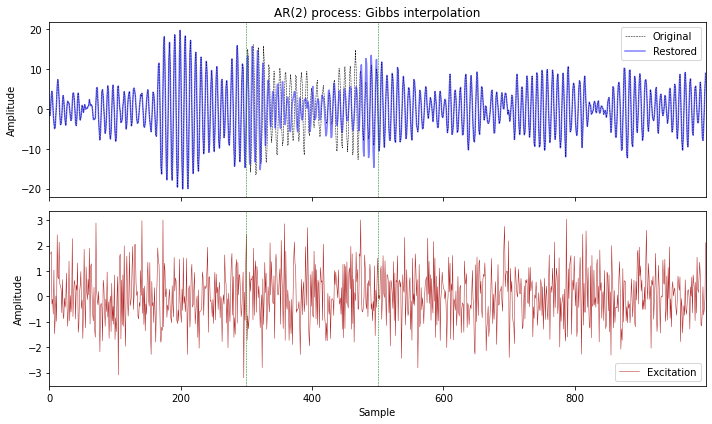

In [9]:
# generate data from the AR process
poles = [0.7 + 1j * 0.7, 0.7 - 1j * 0.7]
n = 1000
data = generate_ar_data(n, poles)

# get 
m = 300  # index of first sample of the remove data
k = 200  # length of removed data
chopped = chopped_data(data, m, k)

# use Gibbs sampling with 50 samples and an AR order of 2
p = 2  # AR order
nsamples = 50
chain = gibbs_sampler(chopped, m, k, p=p, nsamples=nsamples)

# get z and theta for the final sample
z, theta, sigma = chain[-1]

# plot the results
plot_results(data, chopped, z, theta, m, title="AR(2) process: Gibbs interpolation");

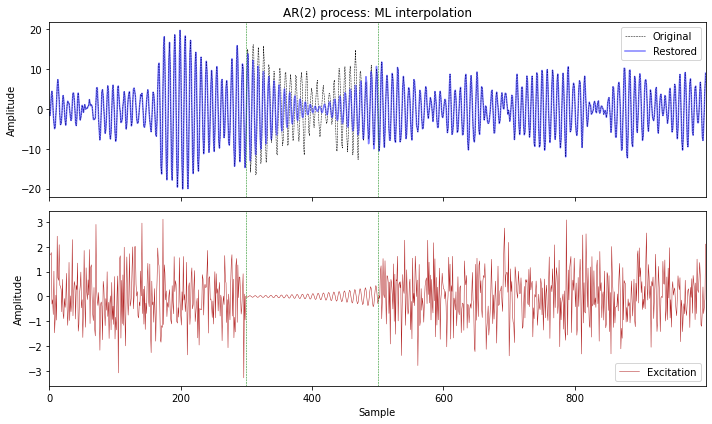

In [10]:
# use ML method
z, theta, sigma = maximum_likelihood(chopped, m, k, p=p)

plot_results(data, chopped, z, theta, m, title="AR(2) process: ML interpolation");

Now, we will use a Gaussian AR process that generates the data having three poles at $0.5 + i0.5$, $0.5 - 0.5i$ and $0.5$. This will again be generated with 1000 samples, but with the missing data starting going from the samples 500 to 649. We will again use the Gibbs sampler and maximum likelihood methods to interpolated the missing data.

100%|████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 86.96it/s]


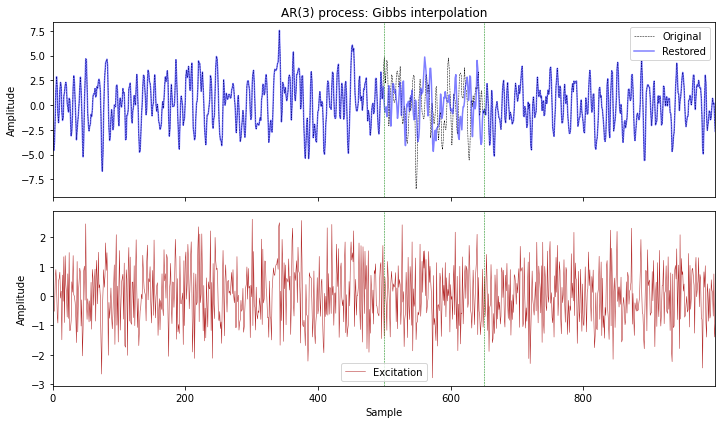

In [11]:
poles = [0.5 + 1j * 0.5, 0.5 - 1j * 0.5, 0.5]

n = 1000
data = generate_ar_data(n, poles)

# get 
m = 500  # index of first sample of the remove data
k = 150  # length of removed data
chopped = chopped_data(data, m, k)

# use Gibbs sampling with 50 samples and an AR order of 3
p = 3  # AR order
nsamples = 50
chain = gibbs_sampler(chopped, m, k, p=p, nsamples=nsamples)

# get z and theta for the final sample
z, theta, sigma = chain[-1]

# plot the results
plot_results(data, chopped, z, theta, m, title="AR(3) process: Gibbs interpolation");

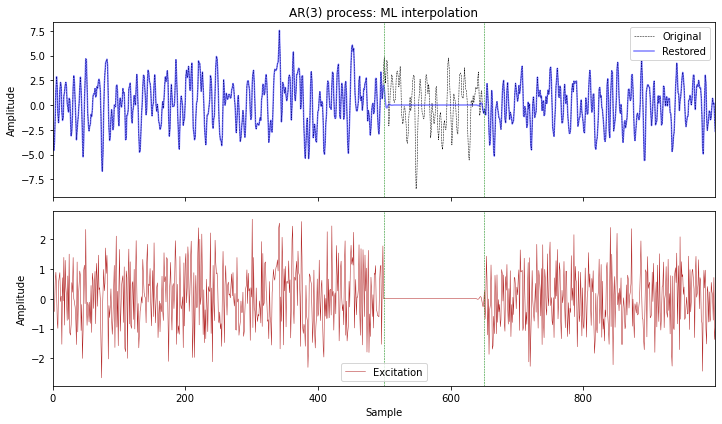

In [12]:
# use ML method
z, theta, sigma = maximum_likelihood(chopped, m, k, p=p)

plot_results(data, chopped, z, theta, m, title="AR(3) process: ML interpolation");

Now, as in Chapter 6.7.3 of Ó Ruanaidh & Fitzgerald, we will generate some fake data consisting of a pure sinusoid with no added noise, i.e., 1000 samples of a sinusoid with a period that matches 200 samples. There are 500 "missing" samples starting at sample 200. We will assume an AR(2) process when interpolating the data.

100%|████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.08it/s]


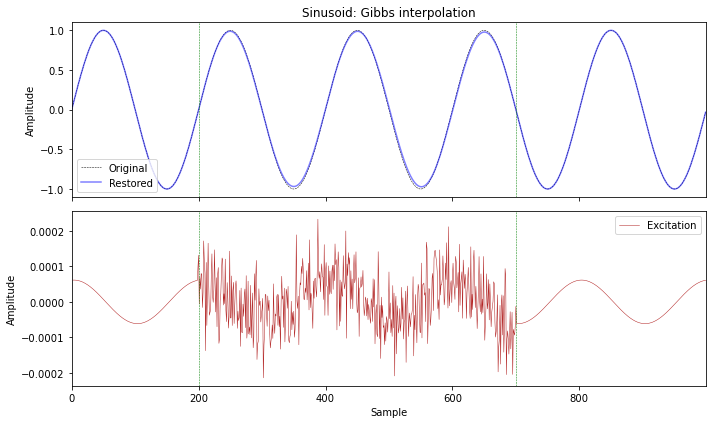

In [13]:
# generate sinusoid
dt = 1
t = np.arange(1000)  # time
f = 1 / 200  # frequency
phi0 = 0.0  # initial phase
data = np.sin(2 * np.pi * f * t + phi0)

# chop out "missing data"
k = 500  # number of missing samples
m = 200  # start of missing samples
chopped = chopped_data(data, m, k)

p = 2  # order of the AR process
nsamples = 50  # draw 50 samples using the Gibbs sampler

# run the Gibbs sampler
chain = gibbs_sampler(chopped, m, k, p=p, nsamples=nsamples)

# get z and theta for the final sample
z, theta, sigma = chain[-1]

# plot the results
plot_results(data, chopped, z, theta, m, title="Sinusoid: Gibbs interpolation");

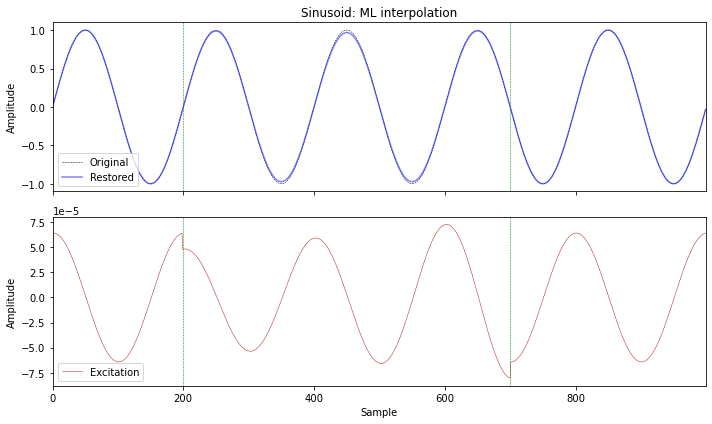

In [14]:
# use ML method (we'll use 14 iterations to be consistent with book)
z, theta, sigma = maximum_likelihood(chopped, m, k, p=p, niter=14)

plot_results(data, chopped, z, theta, m, title="Sinusoid: ML interpolation");

We'll repeat the sine wave example above, but with Gaussian noise added to the signal. When interpolating we will increase the order of the AR process to 80.

100%|████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 40.45it/s]


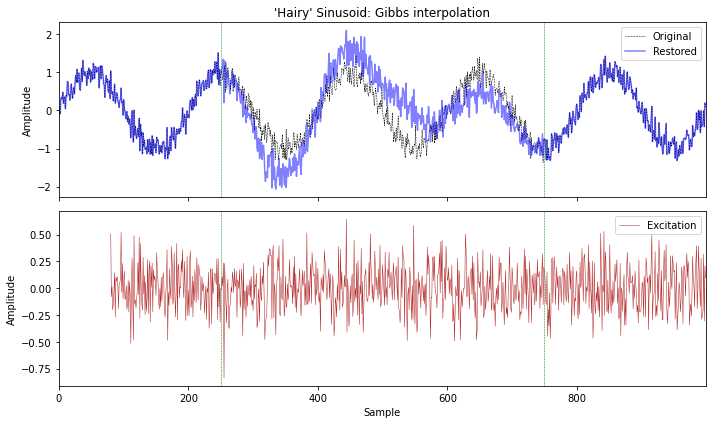

In [15]:
# generate sinusoid (and add noise)
dt = 1
t = np.arange(1000)  # time
f = 1 / 200  # frequency
phi0 = 0.0  # initial phase
data = np.sin(2 * np.pi * f * t + phi0)

rng = np.random.default_rng()
data = data + rng.normal(scale=0.2, size=len(data))

# chop out "missing data"
k = 500  # number of missing samples
m = 250  # start of missing samples
chopped = chopped_data(data, m, k)

p = 80  # order of the AR process
nsamples = 50  # draw 50 samples using the Gibbs sampler

# run the Gibbs sampler
chain = gibbs_sampler(chopped, m, k, p=p, nsamples=nsamples)

# get z and theta for the final sample
z, theta, sigma = chain[-1]

# plot the results
plot_results(data, chopped, z, theta, m, title="'Hairy' Sinusoid: Gibbs interpolation");

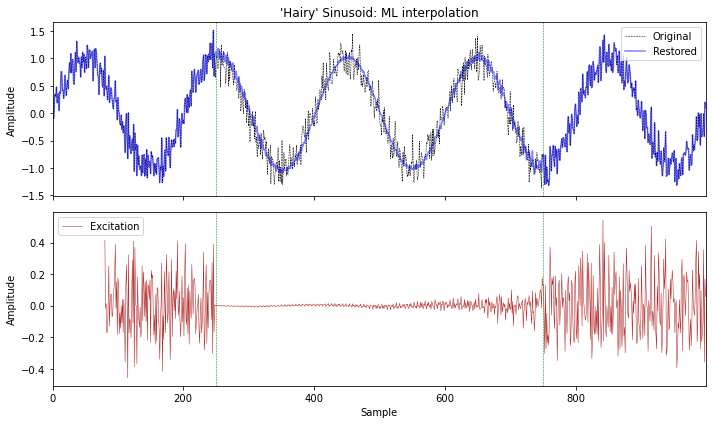

In [16]:
# use ML method (we'll use 14 iterations to be consistent with book)
z, theta, sigma = maximum_likelihood(chopped, m, k, p=p, niter=14)

plot_results(data, chopped, z, theta, m, title="'Hairy' Sinusoid: ML interpolation");

Now, we'll look at some real audio data that contains a glitch (due to a CD scratch). We'tt cut the audio around the glitch and then try interpolating over it. 

In [17]:
from scipy.io import wavfile
from IPython.display import Audio
samplerate, data = wavfile.read('snippet.wav')

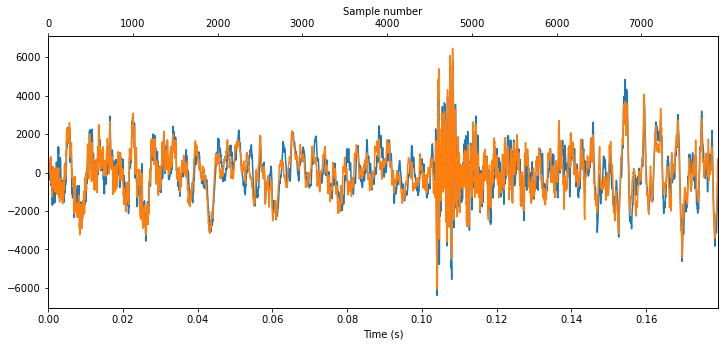

In [18]:
# look at the (LR) data
dl = len(data) / samplerate
times = np.arange(0, dl, 1 / samplerate)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ax.plot(times, data[:, 0], label="left")
ax.plot(times, data[:, 1], label="right")
ax.set_xlabel("Time (s)");
ax.set_xlim([0, times[-1]])

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([xv for xv in times[::1000]]);
ax2.set_xticklabels([f"{i}" for i in np.arange(0, len(data), 1000)]);
ax2.set_xlabel("Sample number");

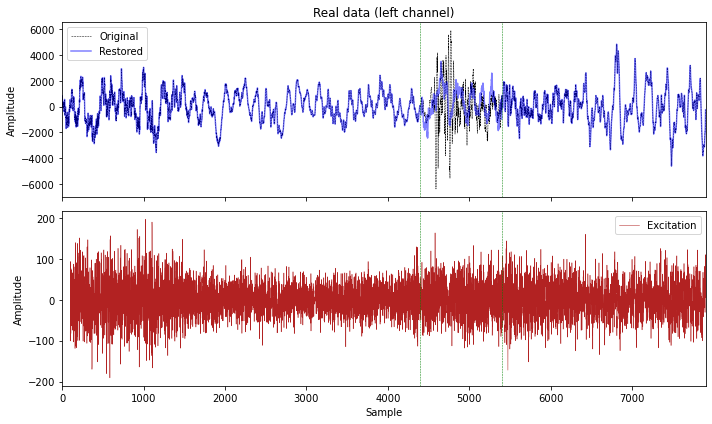

In [21]:
# remove 1000 samples starting from 4400
m = 4400
k = 1000

choppedL = chopped_data(data[:, 0], m, k)

p = 100  # order of the AR process
nsamples = 50  # draw 50 samples using the Gibbs sampler

# run the Gibbs sampler
#chain = gibbs_sampler(choppedL, m, k, p=p, nsamples=nsamples)

# get z and theta for the final sample
z, theta, sigma = chain[-1]

plot_results(data[:, 0], choppedL, z, theta, m, title="Real data (left channel)");

In [27]:
# play at a 10th of the sample rate
Audio(data=restored_data(choppedL, z, m), rate=int(samplerate/10))

In [29]:
Audio(data=data.T, rate=int(samplerate/10))